# Projet python 2A : évaluation de la valeure des footballeurs

César Fabiani - Mathis Lecoq

_Ce projet est réalisé dans le cadre du cours de Python de Lino Galiana pour l'année 2023-2024._

### Introduction

**Notre objectif** : Evaluer la valeur d'un joueur. Pour cela nous avons utilisé les données sur le site [**FB**REF](https://fbref.com/fr/) qui contiennent des données détaillés (buts, passes, etc) pour chaque joueur dans chaque match.

**Le projet** : Notre projet se décompose en N étapes : 
1. Extraction des données en scrappant le site [**FB**REF](https://fbref.com/fr/)
2. Identification des variables d'intérets
3. ...

### Structure du répertoire

À la racine du répertoire, on trouve :
- **`README.md`** : présentation détaillée du projet

### Installations et importations

La partie scrapping prenant beaucoup de temps pour éviter de se faire bloquer par le site, elle n'est pas incluse dans ce notebook. Vous pouvez la trouver dans le fichier **`scrapping`**.
Pour information, les installations et importations sont les suivantes :

In [49]:
!sudo apt-get install python3-pip python-dev
!pip install lxml

import bs4
import lxml
import urllib
import requests

from bs4 import BeautifulSoup
from urllib import request

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python3-pip
E: Unable to locate package python-dev


De plus, on utilise le module **`time`** pour espacer les requêtes et le module **`json`** pour stocker les données recueillies : 

In [50]:
import json
import time

Pour traiter les données, nous avons utilisé les modules **`pandas`**, **`numpy`**, **`sklearn`** et **`matplotlib`** :

In [60]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

### Étape 1 : Extraction des données en scrappant le site [**FB**REF](https://fbref.com/fr/)

_Le code de la partie scraping ne se trouve pas dans le notebook car prennant trop de temps pour s'éxecuter. Vous pouvez le trouvez dans le dossier **`scraping`**.

La partie scraping s'est déroulée en deux étapes. Premièrement le programme **`scraping_FBREF_1`** permet pour une ligue donnée et une saison donnée d'avoir l'ensemble des url des rapports de match correspondant à cette ligue et à cette saison. La liste des url des matchs est exportée vers le fichier json **`liste_url.json`**. Ensuite, les url récoltées sont utilisées par le programme **`scrap_ligue`** qui vient scrapper les tableaux rassemblant les données de chaque joueur. Ainsi une ligne de ce tableau correspond à la performence d'un joueur lors d'un match. Puis les données sont exportées vers le fichier **`statistiques`**. Voici pour exemple les premières lignes du fichier : 

In [52]:
path = "data/data_premierleague_2022_2023_V1.csv"
df_FBREF = pd.read_csv(path)
print(df_FBREF.head())

   Unnamed: 0                Joueur  Numéro de maillot   Nation Emplacement  \
0           0       Odsonne Édouard                 22   fr FRA          FW   
1           1  Jean-Philippe Mateta                 14   fr FRA          FW   
2           2         Wilfried Zaha                 11   ci CIV          LW   
3           3           Jordan Ayew                  9   gh GHA       RW,AM   
4           4          Eberechi Eze                 10  eng ENG          AM   

      Âge  Minutes  Buts  Passes décisives_x  Pénaltys marqués  ...  \
0  24-201       57     0                   0                 0  ...   
1  25-038       33     0                   0                 0  ...   
2  29-268       90     0                   0                 0  ...   
3  30-328       90     0                   0                 0  ...   
4  24-037       85     0                   0                 0  ...   

   Centres_y  Interceptions  Tacles réussis_y  Pénaltys réussis  \
0          0              0    

Une fois la base de données obtenue, nous avons nettoyé la base afin d'obtenir des données sur lesquelles nous pouvons travailler. 

### Étape 2 : Scrapping du site Transfermarkt

In [53]:
path = "/home/onyxia/work/evaluation_football/data/tm.csv"
df_tm = pd.read_csv(path)
df_tm.columns = ['Joueur', 'Valeur', 'Date naissance']
print(df_tm.head())

          Joueur        Valeur     Date naissance
0        Ederson  40,00 mio. €  17 août 1993 (29)
1  Stefan Ortega   9,00 mio. €   6 nov. 1992 (30)
2   Zack Steffen   3,50 mio. €   2 avr. 1995 (28)
3   Scott Carson       200 K €  3 sept. 1985 (37)
4     Rúben Dias  80,00 mio. €   14 mai 1997 (26)


### Étape 3 : Nettoyage des données et fusion des deux bases

Ici il faut mettre ce qui est dans le cleaning pour clean la base FBref (notamment clarifier les positions, c'est le plus important car le modèle est bancal à cause de ça pour l'instant)+ il faut clean la base transfermarkt (transformer les valeurs qui sont en string en valeur numérique avec 30 mil qui devient 30 et 500k qui devient 0.5).

En suite on peut merge les deux bases en faisant un left join . Le code de ça est pour l'instant dans la partie modèle et est un peu brouillon je le 

Une fois ça fait ça nous crée notre base de travail. Je sais pas si on l'exporte ou non. En soit on peut la conserver dans le code pour la suite ou la save et la réouvrir ensuite

Afin de pouvoir faire des statistiques et d'évaluer la valeur des footballeurs, nous devons nettoyer la base issue du site FBREF. Ce nettoyage comporte trois points.

Premièrement, nous devons rajouter à chaque ligne le nombre de point gagnés à l'issu du match (3 pour une victoire, 1 pour une égalité, 0 pour une défaite), pondéré par le temps que le joueur a passé à jouer.

In [54]:
df_FBREF["home"] = np.where(df_FBREF["id_team_A"] == df_FBREF["team tag"], True, False)

def points_gagnes(row):
    """
    This function determines wich teams won, or if there is an equality and return points accordingly.
    """
    if row["id_team_A"] == row["team tag"]:
        if row["score_team_A"] > row["score_team_B"]:
            return 3
        elif row["score_team_A"] == row["score_team_B"]:
            return 1
        else: 
            return 0
    else:
        if row["score_team_B"] > row["score_team_A"]:
            return 3
        elif row["score_team_B"] == row["score_team_A"]:
            return 1
        else:
            return 0

df_FBREF['pts_gagnes'] = df_FBREF.apply(points_gagnes, axis=1)
df_FBREF['pts_apportes'] = df_FBREF['pts_gagnes'] * df_FBREF["Minutes"] / 90

Ensuite nous devons simplifier les positions des joueurs, en effet pour évaluer la valeur d'un joueur, nous devons prendre en compte sa position (un défenseur n'a pas pour objectif de marquer des buts). Cependant il y a trop de position fournies par le site. Nous avons donc condensé les positions en seulement trois positions : attaquant, milieu, défenseur. Nous supprimons également les joueurs ayant le rôle de gardient de but qui est très différent des autres rôles.

In [55]:
# eliminate Goal Keepers
df_FBREF = df_FBREF.loc[df_FBREF['Emplacement'] != 'GK']
df_FBREF = df_FBREF.reset_index(drop=True)

def positions(position):
    """
    This function is used to replace the position of each players by a simpler one.
    The only position left are : "Attaquant", "Défenseur" and "Milieu".
    """
    position = position[:2]
    if position in ['FW','LW','RW']:
        return 'Attaquant'
    elif position in ['DF','FB','LB','RB','CB','WB']:
        return 'Défenseur'
    elif position in ['MF','AM','DM','CM','LM','RM','WM']:
        return 'Milieu'

df_FBREF['Emplacement'] = df_FBREF['Emplacement'].apply(positions)

Ensuite nous devons nettoyer la base obtenue à partir du site Transfermrkt. Cela consiste simplement à remplacer les chaines de caractères correspondant au prix des joueurs en flotants.

In [56]:
# supress the line with no price
df_tm = df_tm.loc[df_tm['Valeur'] != '-']
df_tm = df_tm.reset_index(drop=True)

def str_to_float(str):
    """
    This function convert a string to a float.
    """
    L = str.split()
    L[0] = L[0].replace(",",".")
    if L[1]=='K':
        return float(L[0])*1000
    elif L[1]=='mio.':
        return float(L[0])*1000000
    else :
        return None


df_tm['Valeur'] = df_tm['Valeur'].apply(str_to_float)

Nous pouvons enfin fusionner les deux bases de données.

In [57]:
df_FBREF.set_index('Joueur', inplace= True)
df_tm.set_index('Joueur', inplace= True)

base_work = pd.merge(df_FBREF, df_tm, how='left', left_index=True, right_index=True)
base_work = base_work.sort_values(by = "Unnamed: 0")  # que fait cette ligne ??? (c'état "Unnamed: 0.1 mais j'ai corrigé car sinon ça ne marchait pas")
base_work['Joueur'] = base_work.index
base_work = base_work.reset_index(drop = True)
col_joueur = base_work.pop('Joueur')
base_work.insert(0, 'Joueur', col_joueur)
print(base_work.head())
print(base_work['Valeur'].isna().sum())

                Joueur  Unnamed: 0  Numéro de maillot  Nation Emplacement  \
0       Erling Haaland           0                  9  no NOR   Attaquant   
1       Erling Haaland           0                  9  no NOR   Attaquant   
2       Philip Billing           0                 29  dk DEN   Attaquant   
3  Aleksandar Mitrović           0                  9  rs SRB   Attaquant   
4  Aleksandar Mitrović           0                  9  rs SRB   Attaquant   

      Âge  Minutes  Buts  Passes décisives_x  Pénaltys marqués  ...  \
0  22-073       90     3                   2                 0  ...   
1  22-079       90     1                   0                 0  ...   
2  26-070       64     0                   0                 0  ...   
3  27-338       89     1                   0                 0  ...   
4  27-348       90     1                   0                 0  ...   

   But contre son camp  Récupérations de balle  Aerials Won  Aerials Lost  \
0                    0           

### Étape 4 : Statistiques descriptives

Le but de notre modèle est de calculer l'impact d'une action (passe, tir, dribble,...) sur le match. Une fois son impact (positif ou négatif) calculé, nous pouvons en déduire la valeur d'un joueur en regardant le nombre de fois qu'un joueur va faire chaque action.

Pour les actions, nous allons conserver à priori toutes les actions "en jeu" (passe, tir,...) mais éliminer toutes les actions "hors jeu" (pénalty, corner,...). En effet tout joueur peut effectuer cette action et le choix ne démontre pas une meilleure qualité du joueur. Bien sur un joueur réalisant systématiquement ce genre d'action aura en réalité une meilleure valeur que ce qui est prédit dans le modèle. Mais il ne nous est pas possible d'en tenir compte.

Afin de voir qu'elles actions peuvent être considérés comme déterminantes pour déterminer la valeur un joueur, nous pouvons analyser la variance de chaque action en fonction des postes. Plus une action a une variance grande, plus elle nous permettra de déterminer la valeur d'un joueur.

Comme les données comparées avaient des plages de valeurs très différentes les une des autres, nous avons corrigé la variance en divisant par l'espérence 

In [79]:
actions = ['Buts','Passes décisives_x','Total des tirs ','Shots on Target','Cartons jaunes_x',
'Cartons rouges_x','Touches_x','Tacles_x','Interceptions_x','Balles contrées_x','Actions menant à un tir',
'Actions menant à un but','Passes réussies_x','Passes tentées_x','% de passes réussies_x','Passes progressives_x',
'Balle au pied_x','Possessions progressives_x','Dribbles tentés_x','Dribbles réussis_x',
'Distance totale des passes',"Distance parcourue vers l'attaque avec les passes",'Passes réussies (Court)',
'Passes tentées (Court)','% de passes réussies (Court)','Passes réussies (Moyen)','Passes tentées (Moyen)',
'% de passes réussies (Moyen)','Passes réussies (Long)','Passes tentées (Long)','% de passes réussies (Long)',
'Passes clés','Passes dans le dernier tiers du terrain','Passes dans la surface de réparation',
'Centres dans la surface de réparation','Passes tentées','Live-ball Passes','Dead-ball Passes',
'Passe en profondeur','Transversales','Centres_x','Throw-ins Taken','Passes réussies','Passes hors-jeux',
'Passes bloquées_x','Tacles réussis_x','Tacles (ZDéf)','Tacles (MilTer)','Tacles (ZOff)','Dribbleurs taclés',
'Dribbles mis en échec','% of Dribblers Tackled','Tacles manqués','Tirs bloqués','Tcl+Int','Dégagements',
'Erreurs','Touches (SurfRépDéf)','Touches (ZDéf)','Touches (MilTer)','Touches (ZOff)','Touches (SurfRépOff)',
'Touches (Ballon vivant)','% de dribbles réussis','Nombre de fois où le joueur a été taclé',
'Pourcentage de tacles subis lors des tentatives de franchissement','Distance totale parcourue avec le ballon',
"Distance parcourue vers l'attaque en portant la balle","Chevauchées dans le dernier tiers",
"Chevauchées dans la surface de réparation","Mauvais contrôle","Perte de balle","Passes reçues",
"Passes progressives reçues","Deuxième carton jaune","Fautes commises","Fautes provoquées","Hors-jeux",
"Interceptions","Pénaltys concédés","But contre son camp","Récupérations de balle","Aerials Won",
"Aerials Lost","% of Aerials Won"]

variances = pd.DataFrame(index=statistiques, columns=base_work['Emplacement'].unique())

for position in base_work['Emplacement'].unique():
    for act in actions:
        variance = base_work[base_work['Emplacement'] == position][act].var(ddof=0)
        variance = variance/base_work[base_work['Emplacement'] == position][act].mean()
        variances.at[act, position] = variance

print(variances.head())


/tmp/ipykernel_64264/3078865154.py:27: RuntimeWarning: invalid value encountered in scalar divide
  variance = variance/base_work[base_work['Emplacement'] == position][act].mean()


                   Attaquant    Milieu Défenseur
Buts                 1.17305  1.283971  0.970278
Passes décisives_x  1.170588  1.021182  1.007351
Total des tirs      1.609197  1.474116  1.433758
Shots on Target     1.319184  1.295379  1.056356
Cartons jaunes_x    0.921495  0.875268  0.863252


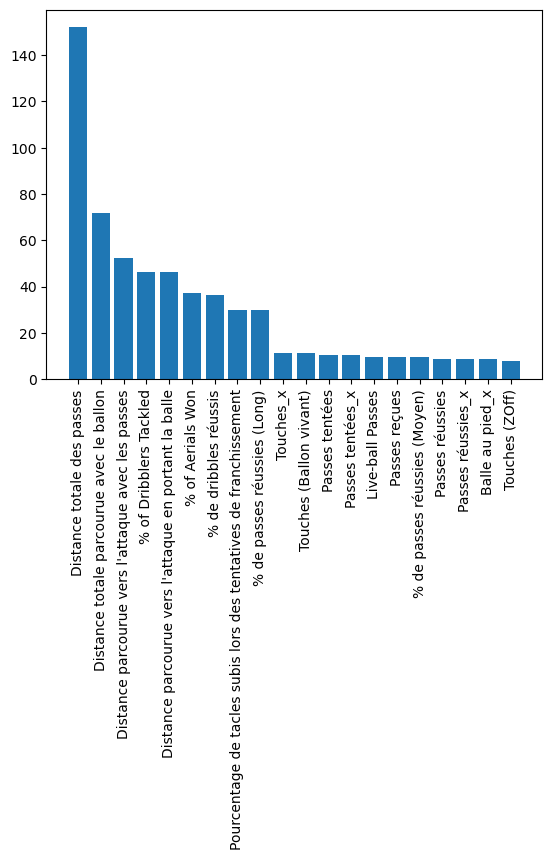

In [80]:
variances=variances.sort_values(by='Attaquant',ascending=False)
plt.bar(variances.head(20).index,variances['Attaquant'].head(20))
plt.xticks(rotation = 'vertical')
plt.show()

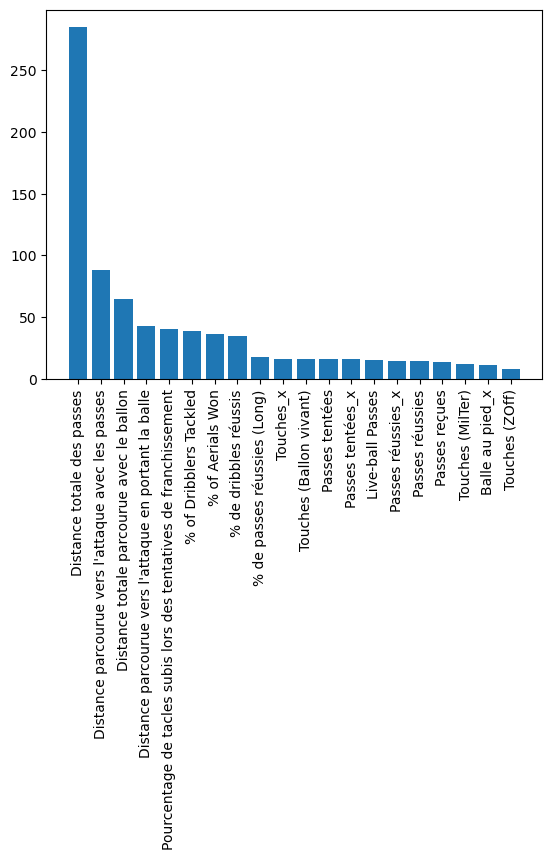

In [77]:
variances=variances.sort_values(by='Milieu',ascending=False)
plt.bar(variances.head(20).index,variances['Milieu'].head(20))
plt.xticks(rotation = 'vertical')
plt.show()

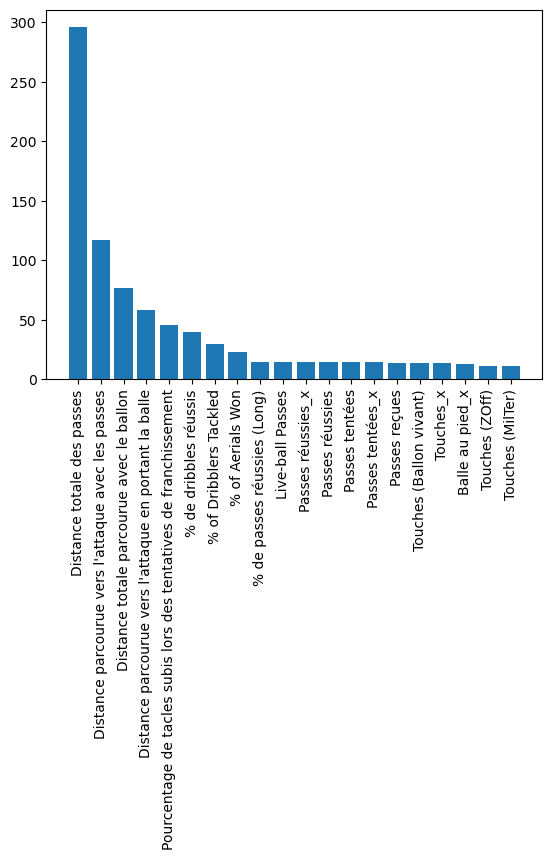

In [78]:
variances=variances.sort_values(by='Défenseur',ascending=False)
plt.bar(variances.head(20).index,variances['Défenseur'].head(20))
plt.xticks(rotation = 'vertical')
plt.show()

### Étape 5 : Modèle

Je mets le modèle temporaire en chargeant des bases.
Comme le merge des deux bases n'est pas encore fait, je le fait là mais infine faudra le placer plus haut

Ci-dessous merge temporaire qui sera replacer au dessus

In [ ]:
data_pl = pd.read_csv("/home/onyxia/work/evaluation_football/data/df_PL.csv")
right = pd.read_csv("/home/onyxia/work/evaluation_football/data/tm.csv")
data_pl.set_index('Joueur', inplace= True)
right.columns = ['Joueur', 'Valeur', 'Date naissance']
right.set_index('Joueur', inplace= True)

base_work = pd.merge(data_pl, right, how='left', left_index=True, right_index=True)
base_work = base_work.sort_values(by = "Unnamed: 0.1")
base_work['Joueur'] = base_work.index
base_work = base_work.reset_index(drop = True)
col_joueur = base_work.pop('Joueur')
base_work.insert(0, 'Joueur', col_joueur)
print(base_work)
print(base_work['Valeur'].isna().sum())

                     Joueur  Unnamed: 0.1  Unnamed: 0  Numéro de maillot  \
0           Odsonne Édouard             0           0                 22   
1      Jean-Philippe Mateta             1           1                 14   
2             Wilfried Zaha             2           2                 11   
3               Jordan Ayew             3           3                  9   
4              Eberechi Eze             4           4                 10   
...                     ...           ...         ...                ...   
11835            Nathan Aké         11340          23                  6   
11836          Shea Charles         11341          24                 62   
11837       Aymeric Laporte         11342          25                 14   
11838           Kyle Walker         11343          26                  2   
11839               Ederson         11344          27                 31   

        Nation Emplacement     Âge  Minutes  Buts  Passes décisives_x  ...  \
0       f

In [ ]:
def buts_equipe(row):
    if row["id_team_A"] == row["team tag"]:
        return row['score_team_A']
    else:
        return row['score_team_B']

base_work['buts_equipes'] = base_work.apply(buts_equipe, axis=1)

data_pl_2 = base_work[base_work['Emplacement'].isin(['AM','FW', 'LW', 'RW'])]

In [ ]:
y = base_work['buts_equipes'].values.reshape(-1,1)

def reg_simple(x,y):
    reg = linear_model.LinearRegression()
    reg.fit(x, y)
    y_pred = reg.predict(x)

    intercept = reg.intercept_
    slope = reg.coef_[0]
    mse = mean_squared_error(y,y_pred)
    r2 = r2_score(y,y_pred)
    
    return intercept, slope, mse, r2

In [ ]:
Var_forward = ['Buts', 'Passes décisives_x','Pénaltys marqués', 'Pénaltys tirés', 'Total des tirs ',
       'Shots on Target', 'Cartons jaunes_x', 'Cartons rouges_x', 'Touches_x',
       'Tacles_x', 'Interceptions_x', 'Balles contrées_x','Actions menant à un tir',
       'Actions menant à un but', 'Passes réussies_x', 'Passes tentées_x',
       'Passes progressives_x', 'Balle au pied_x','Possessions progressives_x', 'Dribbles tentés_x', 'Dribbles réussis_x'
       ]

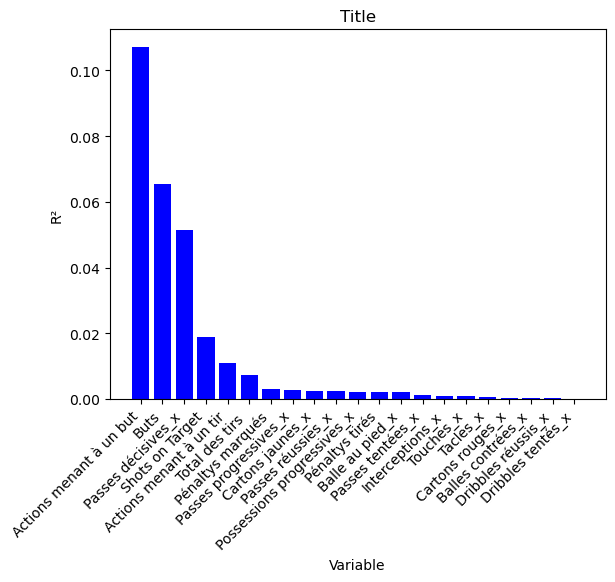

In [ ]:
stat_forward = Var_forward
dict_forward = {}
for stat in stat_forward:
    x = base_work[[stat]]
    result_reg = reg_simple(x,y)
    #print(result_reg)
    dict_forward[stat] = result_reg



var = dict_forward.keys()
r2list = [ele[3] for ele in dict_forward.values()]

sorted_data = sorted(zip(var, r2list), key=lambda x: x[1], reverse=True)
var_sorted, r2list_sorted = zip(*sorted_data)

plt.bar(var_sorted, r2list_sorted, color='blue')
plt.xlabel('Variable')
plt.ylabel('R²')
plt.title('Title')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
var_retenues = ['Buts','Passes décisives_x','Shots on Target','Total des tirs ','Passes progressives_x']
x = data_pl_2[var_retenues]
y = data_pl_2['buts_equipes'].values.reshape(-1,1)
print(reg_simple(x,y))
intercept, coef, _ , _ = reg_simple(x,y)
list_coef = list(coef)

(array([1.20872601]), array([ 1.06627309,  1.09055109,  0.01903792, -0.0481089 ,  0.00147594]), 1.411453169583347, 0.20378196189329711)


In [ ]:
data_pl_2['pts joueurs'] = intercept[0] + data_pl_2[var_retenues[0]] * list_coef[0] + \
                                        data_pl_2[var_retenues[1]] * list_coef[1] + \
                                        data_pl_2[var_retenues[2]] * list_coef[2] + \
                                        data_pl_2[var_retenues[3]] * list_coef[3] + \
                                        data_pl_2[var_retenues[4]] * list_coef[4] 

perf_joueur = data_pl_2.groupby('Joueur').agg({'Buts' : 'sum','Minutes' : 'sum', 'pts joueurs': 'sum', 'pts_gagnes': 'sum', 'Valeur' : 'first'}).reset_index()
perf_joueur = perf_joueur[perf_joueur['Minutes'] >= 300]
perf_joueur['pts joueur par 90'] = perf_joueur['pts joueurs'] * 90 / perf_joueur['Minutes']
print(perf_joueur.sort_values(by = 'pts joueur par 90', ascending= True).head(10))

                  Joueur  Buts  Minutes  pts joueurs  pts_gagnes  \
107  Hamed Junior Traorè     0      301     4.622402           4   
222          Pascal Groß     0      382     5.876584           2   
205   Morgan Gibbs-White     0     4272    66.329433          36   
70          Demarai Gray     2     1715    27.106842          24   
7             Alex Iwobi     1      987    16.165588          18   
185      Marcus Rashford     3     1090    18.656340          18   
14       Andreas Pereira     3     2347    40.387388          42   
33       Bruno Fernandes     2     1074    19.657754          24   
79       Dominic Solanke     6     2457    45.237098          38   
21                Antony     4     1579    29.075758          39   

           Valeur  pts joueur par 90  
107  22,00 mio. €           1.382114  
222   8,00 mio. €           1.384536  
205  40,00 mio. €           1.397390  
70   20,00 mio. €           1.422516  
7    28,00 mio. €           1.474066  
185  80,00 mio. €

/tmp/ipykernel_10616/2590174578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pl_2['pts joueurs'] = intercept[0] + data_pl_2[var_retenues[0]] * list_coef[0] + \
